# Projeto Final - Otimização e Computação Evolucionária


## Alunos: Eduardo Ximenes, Matheus Gomes Maranhão, Vitor Peter

O presente projeto foi realizado como atividade de conclusão da disciplina de Otimização e Computação Evolucionária. A atividade consiste no uso dos conhecimentos adquiridos ao longo das aulas, através da aplicação do Algoritmos Genético e Particle Swarm Optimization com o objetivo de realizar a clusterização de um dataset e regressão com seleção de features no outro dataset. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, jaccard_score, r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score


import time

# Loading bar acompanhar o progresso no "treinamento"
import tqdm
from tqdm.notebook import tqdm_notebook

if 'IPython' in globals() and IPython.get_ipython():
    tqdm_func = tqdm_notebook
else:
    tqdm_func = tqdm.tqdm

## Dataset 1: Churn Prediction  
Com este dataset, será feita uma clusterização com o modelo KMeans usando um método fit ajustado por computação evolucionária. A ideia será comparar essa solução com o modelo padrão. A métrica utilizada foi o índice de silhueta.

In [2]:
df_churn = pd.read_csv('./data/churn_prediction.csv')

In [3]:
print(df_churn.head(1))
df_churn.info()

   customer_id  credit_score country  gender  age  tenure  balance  \
0     15634602           619  France  Female   42       2      0.0   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  

In [4]:
X= df_churn.drop('churn',axis=1)
y = df_churn['churn']

gender_mapping = {'Male': 1, 'Female': 0}
X['gender'] = X['gender'].map(gender_mapping).astype('int8')

dummies = pd.get_dummies(X['country'], drop_first=True)
X.drop(['country','customer_id'],axis=1,inplace=True)
X = pd.concat([X, dummies], axis=1)

X.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,False,True


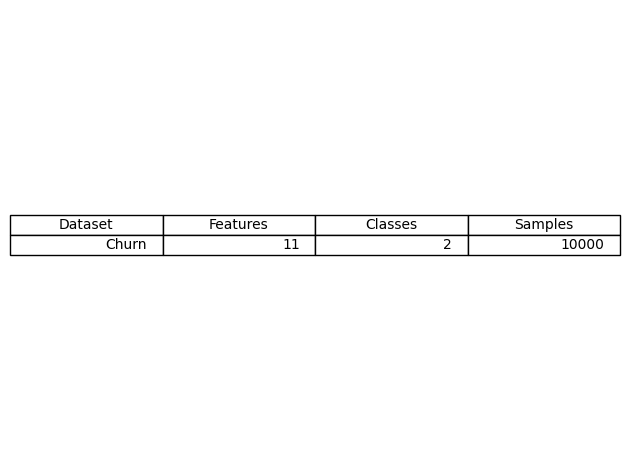

In [5]:
# Plotando tabela com numero de features, classes e samples do dataset

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
ax.table(cellText=[['Churn',X.shape[1],len(y.unique()),X.shape[0]],
                  ],
         colLabels=['Dataset','Features','Classes','Samples'],
         loc='center')
fig.tight_layout()

plt.show()


### Definição de classe para obtenção do baseline para comparação - KMeans

In [6]:
class KMeansEvol(KMeans):
    def __init__(self, n_clusters=2, init='k-means++', precomputed_centroids=None, **kwargs):
        super().__init__(n_clusters=n_clusters, init=init,n_init="auto", **kwargs)
        self.precomputed_centroids = precomputed_centroids # inicializar a variável que recebe os centróides otimizados pelo GA

    def fit(self, X, y=None, sample_weight=None):
        self.cluster_centers_ = self.precomputed_centroids
        self._n_threads = 1 # input para self.predict()
        self.labels_ = self.predict(X)  # Prever partições de cada amostra
        return self

### Definição de Funções para aplicação do GA e PSO

In [7]:
# Funções para o algoritmo genético

def init_pop(P,n_f,n_c, X):
    """
    Inicialize P indivíduos da população. Cada indivíduo contém n_c
    centróides.

    Parâmetros:
    P: Número de indivíduos na população
    n_c: Número de centróides em cada grupo
    n_f: Número de características no conjunto de dados
    X: Conjunto de dados

    Retorna:
    população inicial com P indivíduos
    """
    pop = []
    # loop em todos os indivíduos
    for _ in range(P):
        # Inicializar indivíduo
        centroids = []
        # loop em cada centródide do indivíduo
        for __ in range(n_c):
          # loop em cada feature
          centroid = []
          for feature_index in range(n_f):
              # Gerar a coordenada do centróide associada à feature
              coordinate_f = np.random.uniform(np.min(X[:, feature_index]), np.max(X[:, feature_index]))
              centroid.append(coordinate_f)
          # adicionar centróide ao indivíduo
          centroids.extend(centroid)
        # adicionar indivíduo na pop
        pop.append(np.array(centroids))

    return pop

def fitness_function(ind, n_clusters,n_f, X):

    # Assumindo que o conjunto de centróides de um indivíduo é representado por:
    #np.array([[x1_(1) x1_(2) x1_(3) ... x1_(n_f)] ... [x(n_c)_(1) x(n_c)_(2) x(n_c)_(3) ... x(n_c)_(n_f)] ])
    # onde: n_f-> número de características, n_c-> número de clusters
    # transformar em um array com dimensões (n_clusters x n_f)
    ind_ready = np.reshape(ind, (n_clusters, n_f))

    # Criar instância do KMeansEvol
    kmeans_ga = KMeansEvol(n_clusters=n_clusters, precomputed_centroids=ind_ready)
    kmeans_ga.fit(X)

    # Calcular a métrica silhouette como a fitness do indivíduo
    labels = kmeans_ga.labels_
    if all(x == labels[0] for x in labels): # se somente um cluster existir
      silhouette_avg = -1
    else:
      silhouette_avg = silhouette_score(X, labels)


    # Estamos maximizando a silhouette, então retorne o valor multiplicado por (-1)
    return -silhouette_avg, kmeans_ga

def select_individuals(population):
    """
    Selecione dois indivíduos da população aleatoriamente para P seleções.

    Parâmetros:
    population: Lista ou array representando a população.

    Retorna:
    Lista de tuplas, cada uma contendo os índices de dois indivíduos selecionados aleatoriamente.
    """
    population_size = len(population)
    selections = []

    for _ in range(population_size-1):
        # Selecione dois indivíduos com reposição
        selected_indices = np.random.choice(population_size, size=2, replace=True)
        selections.append(tuple(selected_indices))

    return selections

def uniform_crossover(parent1, parent2, crossover_rate=0.5):
    """
    Realize o cruzamento uniforme entre dois pais.

    Parâmetros:
    parent1: genes do primeiro pai.
    parent2: genes do segundo pai.
    crossover_rate: Probabilidade de selecionar um gene do parent1

    Retorna:
    genes da criança após o cruzamento uniforme.
    """

    # Gerar uma lista aleatória booleana, onde o elemento da lista é igual a True, se p < crossover_rate
    mask = np.random.rand(len(parent1)) < crossover_rate

    # Realizar crossover
    child = np.where(mask, parent1, parent2)

    return child.tolist()


def mutation(child, p_m=0.2, mutation_scale_factor=0.1):
    """

    Aplicar mutação aos genes de uma criança.

    Parâmetros:
    child: genes da criança.
    p_m: Probabilidade de aplicar mutação a cada gene.
    mutation_std_dev: Desvio padrão da distribuição normal para a mutação.

    Retorna:
    genes da criança após a mutação.
    """
    mutated_child = np.copy(child)

    data_std_dev = np.std(child)
    mutation_std_dev = mutation_scale_factor * data_std_dev

    # Faça o loop em cada gene e mute-o com probabilidade p_m
    for i in range(len(child)):
        if np.random.rand() < p_m:
            # Aplique a mutação perturbando o gene com uma distribuição normal
            mutated_child[i] += np.random.normal(loc=0, scale=mutation_std_dev)

    return mutated_child.tolist()

def genetic_algorithm(pop_size, p_crossover, p_mutation, data, n_clusters,n_f, max_generations):

    """
    Loop do algoritmo genético.

    Parâmetros:
    pop_size: Tamanho da população.
    p_crossover: Probabilidade de crossover.
    p_mutation: Probabilidade de mutação.
    X: Conjunto de dados.
    n_clusters: Número de clusters.
    n_features: Número de características.
    max_generations: Número máximo de gerações.

    Retorna:
    Melhor conjunto de centróides obtido pelo algoritmo genético.
    """
    # inicializar os dados
    X = data
    # inicializar pop
    pop = init_pop(pop_size,n_f,n_clusters,X)
    # lista para armazenar evolução da fitness
    fitness_over_time = []
    print('Treinando algorítimo genético...')
    for generation in tqdm_func(range(max_generations), desc="GA Progress"):
        # avaliar fitness dos indivíduos da pop
        #fitness_values = [fitness_function(ind, n_clusters, X) for ind in pop]
        # selecionar melhor indivíduo com base na fitness
        best_ind = min(pop, key=lambda ind: fitness_function(ind, n_clusters,n_f, X)[0])
        # armazenar melhor fitness desta geração
        best_fitness_val, best_kmeans_ga = fitness_function(best_ind, n_clusters,n_f, X)
        fitness_over_time.append(-best_fitness_val)

        # Selecionar pais para reprodução
        selections = select_individuals(pop)

        # Criar nova população com crossover e mutação
        offspring = []
        for parent1, parent2 in selections:
            child = uniform_crossover(pop[parent1], pop[parent2], p_crossover)
            child = mutation(child, p_mutation)
            offspring.append(child)
        offspring.append(best_ind)

        # Atualizar população
        pop = offspring

    return best_ind, fitness_over_time


# Funções para o algoritmo PSO

def init_swarm(P,n_f,n_c, X):
    """
    Inicialize P indivíduos da população. Cada indivíduo contém n_c
    centróides.

    Parâmetros:
    P: Número de partículas no enxame
    n_c: Número de centróides em cada grupo
    n_f: Número de características no conjunto de dados
    X: Conjunto de dados

    Retorna:
    pos = posição inicial das P partículas do enxame
    vel = velocidade inicial das P partículas do enxame
    pos_best = vetor de melhores posições conhecidas pela partícula
    """
    pos = []
    vel = []
    pos_best = []
    # loop em todas as partículas
    for _ in range(P):
        # Inicializar posição da partícula
        centroids = []
        # loop em cada centródide da partícula
        for __ in range(n_c):
          # loop em cada feature
          centroid = []
          for feature_index in range(n_f):
              # Gerar a coordenada do centróide associada à feature
              coordinate_f = np.random.uniform(np.min(X[:, feature_index]), np.max(X[:, feature_index]))
              centroid.append(coordinate_f)
          # adicionar centróide à partícula
          centroids.extend(centroid)
        # adicionar posicao inicial da partícula (grupo de centróides)
        pos.append(np.array(centroids))
        pos_best.append(np.array(centroids))
        # adicionar velocidade inicial da partícula
        vel.append(np.random.uniform(-1,1, size = (n_f*n_c)))


    return pos, vel, pos_best

# atualizar velocidade da partícula
def update_velocity(pos, vel, pos_best, global_best, w, c1, c2):
  '''
    Atualiza a velocidade da partícula usando a fórmula da Otimização por Enxame de Partículas (PSO).

    Parâmetros:
    pos: posição atual da partícula
    vel: velocidade atual da partícula
    pos_best: Melhor posição global entre todas as partículas.
    c1: Parâmetro cognitivo.
    c2: Parâmetro social.
    w: Peso de inércia.

    Retorna:
    - Velocidade atualizada para a partícula.
  '''
  # inicializar vel atualizada
  vel_updated = []
  # loop em cada posição i da partícula
  for i in range(len(pos)):
      # Gera números aleatórios no intervalo [0, 1]
      r1 = np.random.uniform(0,1)
      r2 = np.random.uniform(0,1)

      # Calcula os componentes cognitivo e social da atualização de velocidade
      vel_cognitive = c1 * r1 * (pos_best[i] - pos[i])
      vel_social = c2 * r2 * (global_best[i] - pos[i])

      # Atualiza a velocidade i usando a fórmula do PSO
      vel_updated.append(w * vel[i] + vel_cognitive + vel_social)

  # Retorna a velocidade atualizada para a partícula
  return np.array(vel_updated)

# definir função de atualização da posição
def update_position(pos, vel, bounds):
  '''
    Atualiza a posição da partícula a partir da nova velocidade.

    Parâmetros:
    pos: posição atual da partícula
    vel: velocidade atualizada da partícula
    bounds: limites do ambiente

    Retorna:
    - Velocidade atualizada para a partícula.
  '''
  pos_updated = []
  for i in range(len(pos)):
      pos_updated.append(np.clip(pos[i]+vel[i], a_min=bounds[0], a_max=bounds[1]))
  return pos_updated

def pso(swarm_size, c1, c2, w, data, n_clusters,n_f, max_iters):
  """
  Loop do PSO.

  Parâmetros:
  swarm_size: num de partículas.
  c1: Parâmetro cognitivo.
  c2: Parâmetro social.
  w: Peso de inércia.
  X: Conjunto de dados.
  n_clusters: Número de clusters.
  n_features: Número de características.
  max_iters: Número máximo de períodos.

  Retorna:
  Melhor conjunto de centróides obtido pelo algoritmo genético.
  """
  # inicializar os dados
  X = data
  bounds = [np.min(X), np.max(X)] # valor mínimo e máximo global de X
  # inicializar o enxame
  pos_swarm, vel_swarm, pos_best_swarm = init_swarm(swarm_size,n_f,n_clusters,X)
  # lista para armazenar evolução da fitness
  fitness_over_time = []

  # comece o loop
  best_ind = pos_swarm[0] # initialize global best
  print('Treinando PSO...')
  for iter in tqdm_func(range(max_iters), desc="PSO Progress"):
      # avaliar fitness das partículas do enxame
      global_best_fitness, _ = fitness_function(best_ind, n_clusters,n_f, X) # fitness da melhor posição global
      for j,ind in enumerate(pos_swarm):
        score, _ = fitness_function(ind, n_clusters,n_f, X) # fitness da posição atual
        score_known_best, _ = fitness_function(pos_best_swarm[j], n_clusters,n_f, X) # fitness da melhor posição conhecida
        if score < score_known_best:
          pos_best_swarm[j] = ind # se uma posição melhor for encontrada
        if score < global_best_fitness:
          best_ind = ind

      # armazenar melhor fitness deste período
      best_fitness_val, best_kmeans_pso = fitness_function(best_ind, n_clusters,n_f, X)
      fitness_over_time.append(-best_fitness_val)

      # cycle through swarm and update velocities and position
      for j in range(swarm_size):
          vel_swarm[j] = update_velocity(pos_swarm[j], vel_swarm[j], pos_best_swarm[j], best_ind, w, c1, c2)
          #pos_swarm[j] = update_position(pos_swarm[j], vel_swarm[j], [-1000,1000])
          pos_swarm[j] = update_position(pos_swarm[j], vel_swarm[j], bounds)

  return best_ind, fitness_over_time

### Implementação

In [8]:
# Obtenção do baseline

kmeans = KMeans(n_clusters=2, random_state=0,n_init="auto") 
kmeans.fit(np.array(X))

# The cluster centers (centroids)
centroids = kmeans.cluster_centers_

# The labels of the clusters
labels = kmeans.labels_

silhouette = silhouette_score(np.array(X), labels)


In [9]:
def CompareGAvsPSO(data,popsize,p_crossover,p_mutation,n_clusters,n_f,max_generations,c1,c2,w):

    start_time = time.time()
    GA_best_ind, GA_fitness_over_time = genetic_algorithm(pop_size = popsize,
                              p_crossover = p_crossover,
                              p_mutation = p_mutation,
                              data = data,
                              n_clusters = n_clusters,
                              n_f=n_f,
                              max_generations = max_generations)
    GA_runtime = time.time() - start_time

    start_time = time.time()
    PSO_best_ind, PSO_fitness_over_time = pso(swarm_size = popsize,
                              c1=c1,
                              c2=c2,
                              w=w,
                              data = data,
                              n_clusters = n_clusters,
                              n_f=n_f,
                              max_iters = max_generations)
    PSO_runtime = time.time() - start_time

    
    OutputDict = {'GA_best_ind':GA_best_ind,
                    'GA_fitness_over_time':GA_fitness_over_time,
                    'GA_runtime':GA_runtime,
                    'PSO_best_ind':PSO_best_ind,
                    'PSO_fitness_over_time':PSO_fitness_over_time,
                    'PSO_runtime':PSO_runtime}

    return OutputDict

In [12]:
# Parâmetros constantes para o GA e PSO
data = X.to_numpy()
n_clusters=2
n_f = X.shape[1]

popsize = 100 # = swarmsize
max_generations = 30 # = max_iters

# Parâmetros variáveis para o GA
p_crossover = 0.3
p_mutation = 0.2


# Parâmetros variáveis para o PSO
c1 = 1
c2 = 2
w = 0.5

results = CompareGAvsPSO(data,popsize,p_crossover,p_mutation,n_clusters,n_f,max_generations,c1,c2,2)

Treinando algorítimo genético...


GA Progress: 100%|██████████| 30/30 [51:53<00:00, 103.78s/it]


Treinando PSO...


PSO Progress: 100%|██████████| 30/30 [1:23:26<00:00, 166.87s/it]


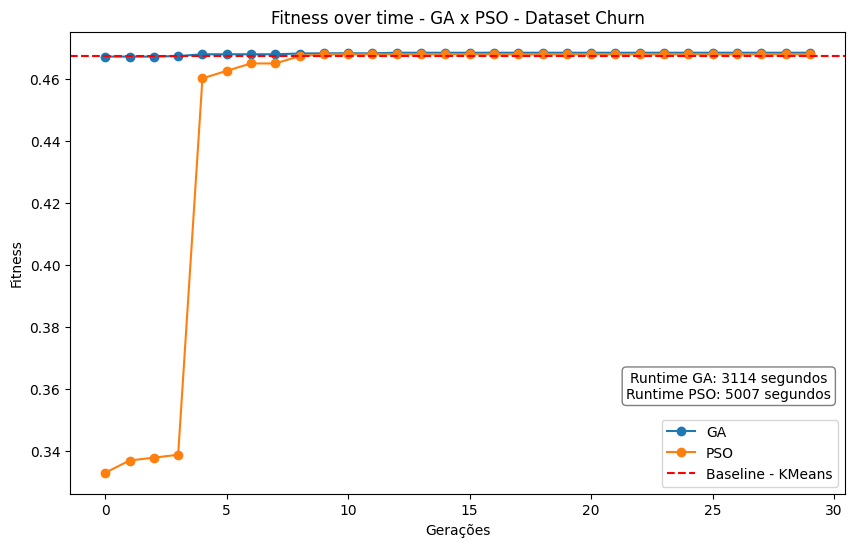

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting Results

ax.plot(results['GA_fitness_over_time'], label='GA', marker='o')
ax.plot(results['PSO_fitness_over_time'], label='PSO', marker='o') 
ax.axhline(y=silhouette, color='r', linestyle='--', label='Baseline - KMeans')
ax.legend()
ax.set_xlabel('Gerações')
ax.set_ylabel('Fitness')
ax.set_title('Fitness over time - GA x PSO - Dataset Churn')

# Plot Runtime results
text_box_runtime_GA = f"Runtime GA: {results['GA_runtime']:.0f} segundos"
text_box_runtime_PSO = f"Runtime PSO: {results['PSO_runtime']:.0f} segundos"
text_box_content = text_box_runtime_GA + '\n' + text_box_runtime_PSO

ax.text(0.85, 0.2, text_box_content, transform=ax.transAxes,
        fontsize=10, verticalalignment='bottom', horizontalalignment='center',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()

## Dataset 2: Housing Prices  
Com este dataset, será feita uma regressão com o modelo SVR usando features selecionadas por computação evolucionária. A ideia será comparar essa solução com o modelo utilizando todas as features, e com o modelo utilizando features escolhidas pelo PCA. As métricas utilizadas foram R² e MSE.

In [6]:
df_housing = pd.read_csv('./data/housing_price.csv')
print(df_housing.head(1))
print(df_housing.info())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int

In [7]:
dict_house_bool = {'no':0, 'yes':1}
booleans_house = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for boolean_col in booleans_house:
    df_housing[boolean_col] = df_housing[boolean_col].map(dict_house_bool)

dict_house_furnish = {False:0, True:1}
dummies_furnish = pd.get_dummies(df_housing.furnishingstatus)
for furnish_col in dummies_furnish:
    dummies_furnish[furnish_col] = dummies_furnish[furnish_col].map(dict_house_furnish)

df_housing = df_housing.drop('furnishingstatus',axis=1)
dummies_furnish = dummies_furnish.drop('unfurnished',axis=1)
for col in dummies_furnish:
    df_housing[col] = dummies_furnish[col]


df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [9]:
def init_pop(P,X):
    """
    Inicialize um conjunto de indivíduos, cada um contendo elementos entre 0 e 1.

    Parâmetros:
    X: dados de treinamento
    P: número de indivíduos na população

    Retorna:
    pop: população inicial
    """
    pop = []
    m, n = X.shape
    for _ in range(P):
        ind = [np.random.uniform(0, 1) for __ in range(n)] # chaves aleatórias
        pop.append(ind)

    return pop

In [10]:
# Função para decodificar o indivíduo
def decode_ind(ind, beta):
    """
    Decodificar um indivíduo definindo 'beta' elementos com a maior
    probabilidade como 1 e os demais como 0.

    Parâmetros:
    ind: indivíduo a ser decodificado.
    beta: O número de elementos a serem definidos como 1.

    Retorna:
    ind: indivíduo a ser decodificado.
    """

    # Obtenha os índices dos 'beta' maiores elementos
    indices_of_highest = sorted(range(len(ind)), key=lambda i: ind[i], reverse=True)[:beta]
    # []

    # Innicialize o indivíduo decodificado
    decoded_ind = [0] * len(ind)

    # Inclua um total de 'beta' elementos iguais a 1
    for index in indices_of_highest:
        decoded_ind[index] = 1

    return decoded_ind

In [111]:
# Função para calcular a fitness
def fitness_function(ind_encoded, beta, X, y):

    # ind é um subconjunto de features: [0 0 1 0 0 1 ...]
    ind = decode_ind(ind_encoded, beta)
    m, n = X.shape

    cols = [i for i in range(n) if ind[i] == 1] # índices das features selecionadas
    X_subset = X[:, cols] # selecionar somente as features selecionadas
    svr = SVR()
    score = -1.0* np.mean(cross_val_score(svr, X_subset, y, cv=10, scoring='neg_mean_squared_error'))

    return score

In [49]:
def select_individuals(population, elite_size): # elitism is used
    """
    Selecionar dois indivíduos aleatoriamente da população P vezes.
    Como utilizamos elitismo, devemos reduzir o número de indivídos selecionados

    Parâmetros:
    population: Lista ou array representando a população.
    elite_size: Tamanho da elite

    Retorna:
    Lista de tuplas, cada uma contendo os índices de dois indivíduos selecionados aleatoriamente.
    """
    population_size = len(population)-math.ceil(elite_size)

    selections = []
    for _ in range(population_size):
        # Selecione dois indivíduos aleatoriamente com reposição
        selected_indices = np.random.choice(population_size, size=2, replace=True)
        selections.append(tuple(selected_indices))

    return selections

In [50]:
def uniform_crossover(parent1, parent2, crossover_rate=0.5):
    """
    Realizar crossover uniforme entre dois pais.

    Parâmetros:

    parent1: genes do primeiro pai.
    parent2: genes do segundo pai.
    crossover_rate: Probabilidade de selecionar um gene do primeiro pai.

    Retorna:
    genes do filho após o crossover uniforme.
    """

    # Gerar uma lista aleatória booleana, onde o elemento da lista é igual a True, se p < crossover_rate
    mask = np.random.rand(len(parent1)) < crossover_rate

    # Realizar crossover
    child = np.where(mask, parent1, parent2)

    return child.tolist()

In [73]:
def mutation(child, p_m=0.2, mutation_std_dev=0.01):
    """

    Aplicar mutação aos genes de uma criança.

    Parâmetros:
    child: genes da criança.
    p_m: Probabilidade de aplicar mutação a cada gene.
    mutation_std_dev: Desvio padrão da distribuição normal para a mutação.

    Retorna:
    genes da criança após a mutação.

    * obs.: o std_dev foi reduzido e 0.1 para 0.01
    """
    mutated_child = np.copy(child)

    # Faça o loop em cada gene e mute-o com probabilidade p_m
    for i in range(len(child)):
        if np.random.rand() < p_m:
            # Aplique a mutação perturbando o gene com uma distribuição normal
            mutated_child[i] += np.random.normal(loc=0, scale=mutation_std_dev)

    return mutated_child.tolist()

In [112]:
def genetic_algorithm(pop_size, p_crossover, p_mutation, data, labels, beta, max_generations, elite_size):
    """
    Loop do GA.

    Parâmetros:
    - pop_size: Population size.
    - p_crossover: Crossover probability.
    - p_mutation: Mutation probability.
    - data: Dataset.
    - labels: labels das amostras.
    - beta: tamanho do subconjunto de features
    - max_generations: Maximum number of generations.
    - elite_size: tamanho da elite

    Retorna:
    - Melhor subconjunto de características obtido pelo GA
    """
    # inicializar os dados
    X = data
    y = labels
    # gerar pop inicial
    pop = init_pop(pop_size,X)
    # Listas para guardar melhores fitness e indivíduos
    fitness_over_time = []
    bestind_over_time = []
    for generation in range(max_generations):
        print("Generation: " + str(generation))
        # Avaliar a fitness de cada indivíduo
        # Encontrar melhores indivíduos de acordo com a fitness
        best_ind = sorted(pop, key=lambda ind: fitness_function(ind, beta, X, y))[:math.ceil(elite_size)]
        # Guardar as melhores fitness e indivíduos
        best_fitness_val = fitness_function(best_ind[0], beta, X, y)
        print("Best Fitness @ Generation: " + str(best_fitness_val))
        fitness_over_time.append(-best_fitness_val)
        bestind_over_time.append(best_ind[0])

        # Selecionar pais para reprodução
        selections = select_individuals(pop, elite_size)

        # Gerar nova pop através de crossover e mutação
        offspring = []
        for parent1, parent2 in selections:
            child = uniform_crossover(pop[parent1], pop[parent2], p_crossover)
            child = mutation(child, p_mutation)
            offspring.append(child)

        # Atualizar população
        pop = offspring
        pop.extend(best_ind)

    return best_ind[0], fitness_over_time, bestind_over_time

In [117]:
X_house = df_housing.drop('price',axis=1).to_numpy()
y_house = df_housing['price'].to_numpy()

scaler = StandardScaler()
X_house = scaler.fit_transform(X_house)

# Escalando também o target apenas para fins estéticos
scaler_y = StandardScaler()
y_house = scaler_y.fit_transform(y_house.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X_house, y_house, test_size=0.2, random_state=0)


In [118]:
beta = 5
pop_size = 300
elite_frac = 0.5
p_crossover = 0.5
p_mutation = 0.2
max_generations = 10

ind_house_ga, fitness_over_time_house_ga, bestind_over_time_house_ga = genetic_algorithm(pop_size=pop_size, elite_size=elite_frac*pop_size, 
                                                                                         p_crossover=p_crossover, p_mutation=p_mutation, 
                                                                                         data=X_train,
                                                                                         labels=y_train.ravel(),
                                                                                         beta=beta, max_generations=max_generations)

best_fit_house_ga = fitness_function(ind_house_ga, beta, X_train, y_train.ravel())
selected_cols_house_ga = [index for index, value in enumerate(decode_ind(ind_house_ga, beta)) if value == 1]

print('Melhor fitness:', best_fit_house_ga)
print('Colunas selecionadas:', selected_cols_house_ga)

Generation: 0
Best Fitness @ Generation: 0.4651183554380706
Generation: 1
Best Fitness @ Generation: 0.4651183554380706
Generation: 2
Best Fitness @ Generation: 0.4651183554380706
Generation: 3
Best Fitness @ Generation: 0.4651183554380706
Generation: 4
Best Fitness @ Generation: 0.46007717883794974
Generation: 5
Best Fitness @ Generation: 0.46007717883794974
Generation: 6
Best Fitness @ Generation: 0.46007717883794974
Generation: 7
Best Fitness @ Generation: 0.46007717883794974
Generation: 8
Best Fitness @ Generation: 0.46007717883794974
Generation: 9
Best Fitness @ Generation: 0.46007717883794974
Melhor fitness: 0.46007717883794974
Colunas selecionadas: [0, 2, 3, 8, 10]


In [121]:
# Definindo baseline de treino e teste
svr_Baseline = SVR()
svr_Baseline.fit(X_train, y_train.ravel())

baseline_mse_train = mean_squared_error(y_train.ravel(), svr_Baseline.predict(X_train))
baseline_mse_test = mean_squared_error(y_test.ravel(), svr_Baseline.predict(X_test))

In [124]:
GA_train_MSE = []
GA_test_MSE = []

for ind in bestind_over_time_house_ga:
    subset = [index for index, value in enumerate(decode_ind(ind, beta)) if value == 1]
    # Extrair o subconjunto de características
    X_subset_train = X_train[:, subset]
    X_subset_test = X_test[:, subset]

    # Inicializar e treinar o regressor
    classifier_subset = SVR()
    classifier_subset.fit(X_subset_train, y_train.ravel())

    # Avaliar o desempenho
    mse_train = mean_squared_error(y_train.ravel(), classifier_subset.predict(X_subset_train))
    mse_test = mean_squared_error(y_test.ravel(), classifier_subset.predict(X_subset_test))

    # Armazenar os resultados
    GA_train_MSE.append(mse_train)
    GA_test_MSE.append(mse_test)

In [127]:
GA_train_MSE

[0.3716803647011674,
 0.3716803647011674,
 0.3716803647011674,
 0.3716803647011674,
 0.37052507370805854,
 0.37052507370805854,
 0.37052507370805854,
 0.37052507370805854,
 0.37052507370805854,
 0.37052507370805854]

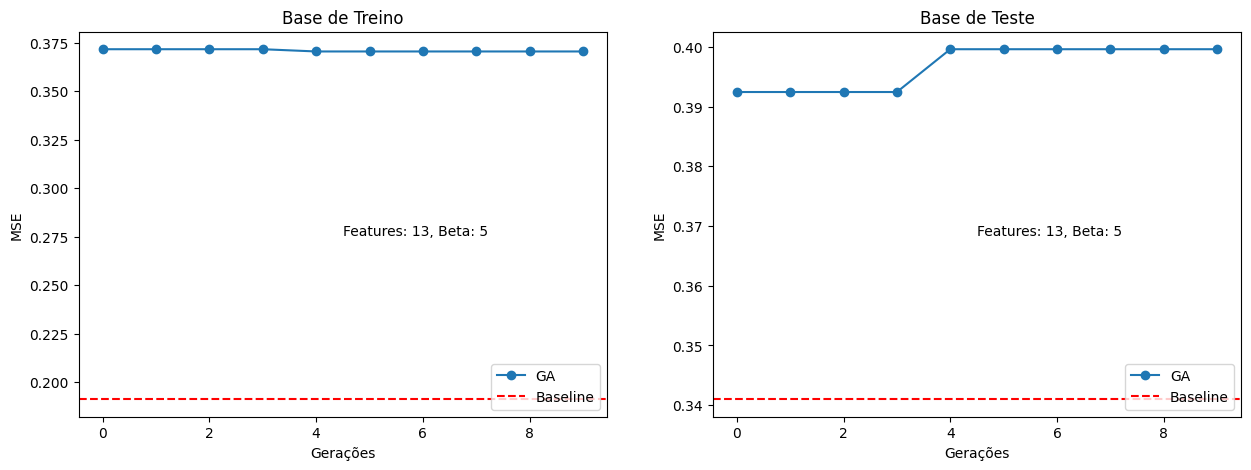

In [131]:
ig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(GA_train_MSE, label='GA', marker='o')
#axs[0].plot(results_1['PSO_train_accuracy'], label='PSO', marker='o')
axs[0].axhline(y=baseline_mse_train, color='r', linestyle='--', label='Baseline')
axs[0].set_title('Base de Treino')
axs[0].set_xlabel('Gerações')
axs[0].set_ylabel('MSE')
axs[0].legend(loc="lower right")
axs[0].text(0.5, 0.5, f"Features: {X_train.shape[1]}, Beta: {beta}", transform=axs[0].transAxes, fontsize=10, verticalalignment='top')


axs[1].plot(GA_test_MSE, label='GA', marker='o')
#axs[1].plot(results_1['PSO_test_accuracy'], label='PSO', marker='o')
axs[1].axhline(y=baseline_mse_test, color='r', linestyle='--', label='Baseline')
axs[1].set_title('Base de Teste')
axs[1].set_xlabel('Gerações')
axs[1].set_ylabel('MSE')
axs[1].legend(loc="lower right")
axs[1].text(0.5, 0.5, f"Features: {X_train.shape[1]}, Beta: {beta}", transform=axs[1].transAxes, fontsize=10, verticalalignment='top')

plt.show()